# Maintenance Project

In [77]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
print("Setup Complete")

import warnings
warnings.filterwarnings("ignore")

Setup Complete


In [3]:
df = pd.read_csv("data/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

## Data Cleaning

In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

There does not seem to be any missing values

In [33]:
dv = df.drop(['UDI', 'Product ID'], axis=1)
feature_columns = ['quality', 'air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear']
target_columns = ['machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
dv.columns = feature_columns + target_columns

dv['quality'] = dv['quality'].astype('category')
cat_columns = ['quality', 'machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
num_columns = ['air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear']

dv.head()

,quality,air_temp,process_temp,rotational_speed,torque,tool_wear,machine_failure,twf,hdf,pwf,osf,rnf
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [26]:
dv.dtypes

quality             category
air_temp             float64
process_temp         float64
rotational_speed       int64
torque               float64
tool_wear              int64
machine_failure        int64
twf                    int64
hdf                    int64
pwf                    int64
osf                    int64
rnf                    int64
dtype: object

## Data Visualization

<AxesSubplot:xlabel='process_temp', ylabel='Count'>

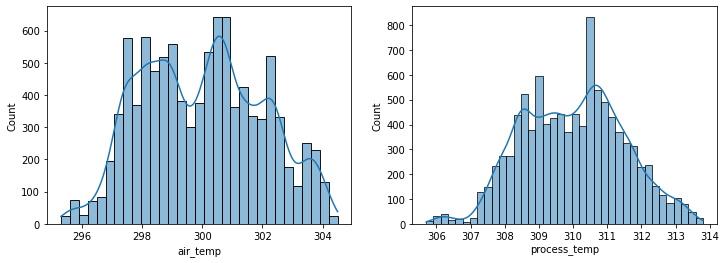

In [32]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data=dv, x='air_temp', kde=True, ax=ax[0])
sns.histplot(data=dv, x='process_temp', kde=True, ax=ax[1])

Interestingly, air temperature and process temperature are bimodal

<AxesSubplot:xlabel='quality', ylabel='count'>

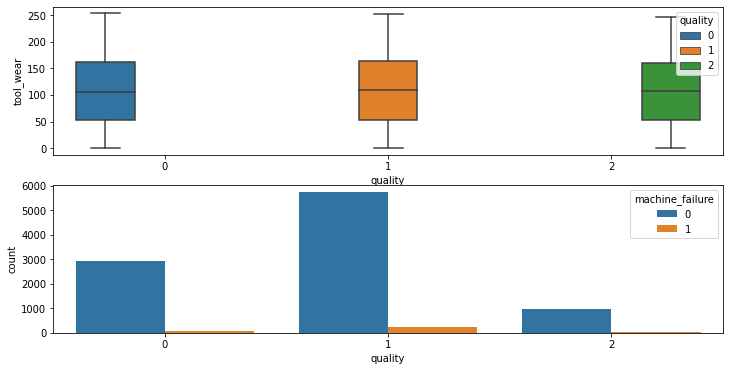

In [117]:
fig, ax = plt.subplots(nrows=2, figsize= (12,6))

sns.boxplot(data=dv, x='quality', y='tool_wear', hue='quality', ax=ax[0])

dv_failure = pd.DataFrame()
dv_failure['count'] = dv.groupby(by=['quality','machine_failure']).apply(lambda x: x['machine_failure'].count())
sns.barplot(data=dv_failure.reset_index(), y='count', x='quality',hue='machine_failure', ax=ax[1])

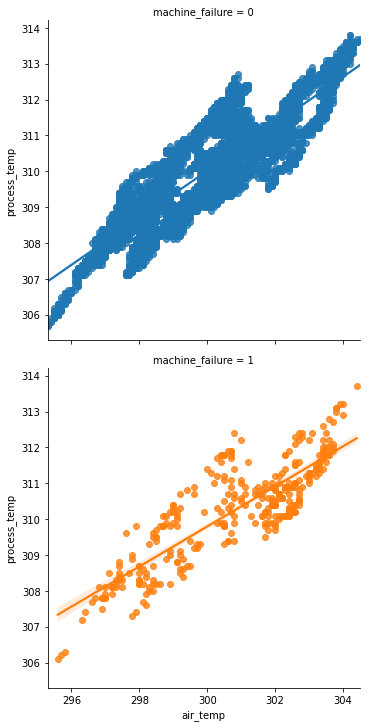

In [121]:
sns.lmplot(data=dv, x='air_temp', y='process_temp', hue='machine_failure', row='machine_failure')

In [56]:
dv_failure['probability'] = dv_failure['count']/dv_failure.groupby(['quality'])['count'].transform(lambda x: x.sum())*100
dv_failure

count  probability
quality machine_failure                    
H       0                  982    97.906281
        1                   21     2.093719
L       0                 5765    96.083333
        1                  235     3.916667
M       0                 2914    97.230564
        1                   83     2.769436

It seems that the higher the quality, the lower the probability that it will experience machine failure

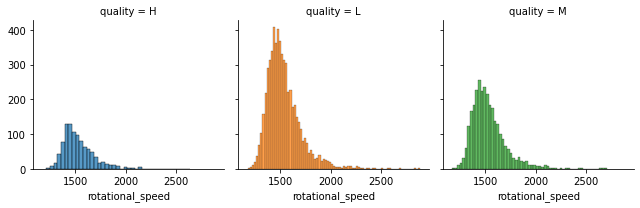

In [30]:
graph = sns.FacetGrid(data=dv, 
                      col='quality', 
                      hue='quality', )
graph.map(sns.histplot, 'rotational_speed')

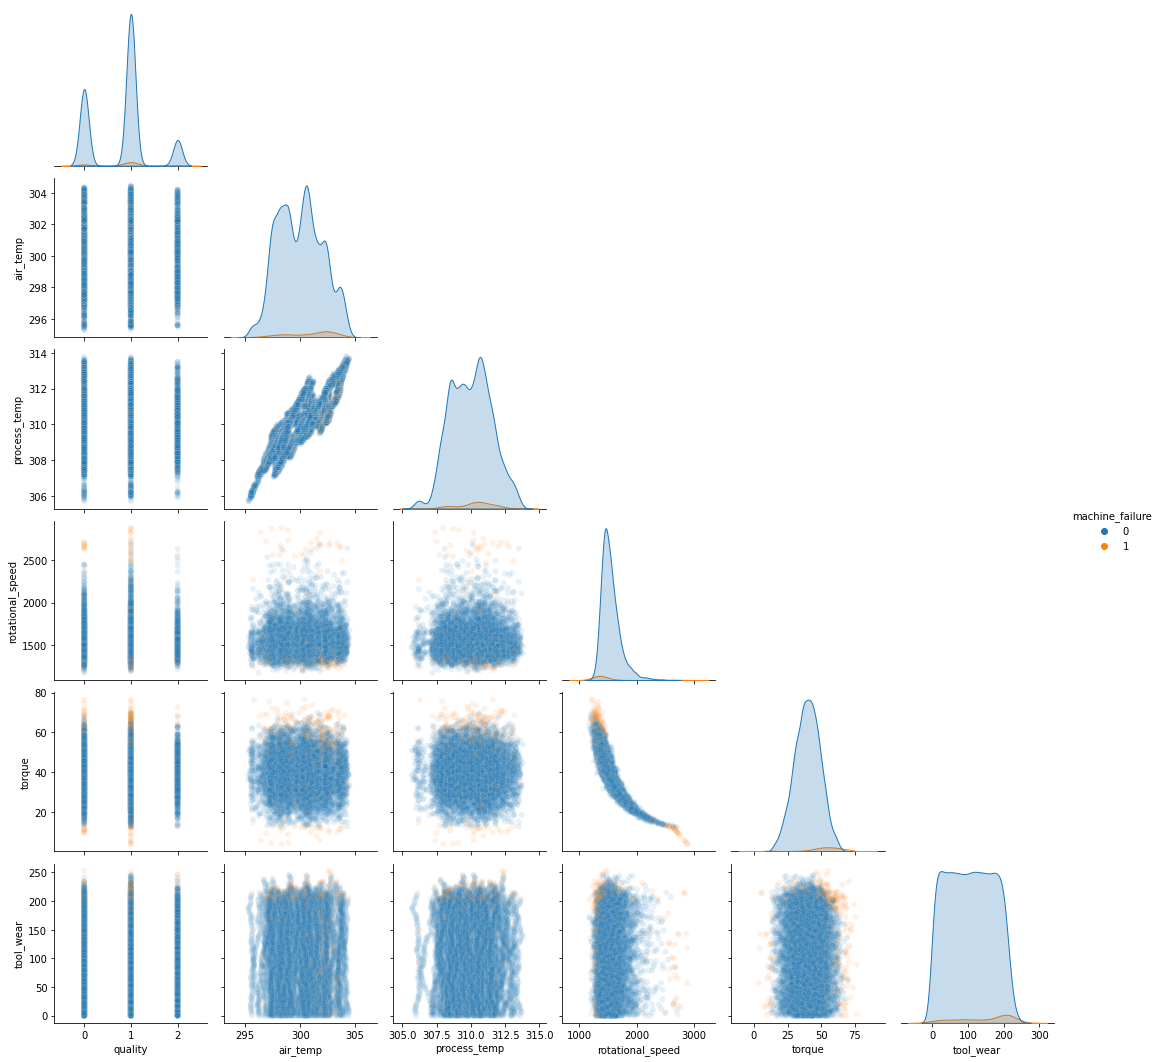

In [76]:
dv['quality'], dv_cat = dv['quality'].factorize()
dv['speed*torque'] = dv['rotational_speed'] * dv['torque']
sns.pairplot(dv[feature_columns+['machine_failure']], hue='machine_failure', plot_kws={'alpha':0.1}, corner=True)

There seems to be linear relationship between `air_temp` and `process_temp`. Furthermore, `rotational_speed` and `torque` are likely to be inversely related.

It is also interesting to note that the distributions of `air_temp` and `process_temp` are bimodal 

<AxesSubplot:>

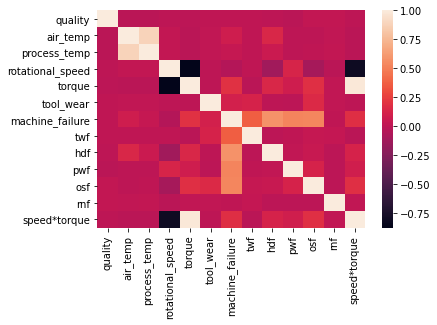

In [78]:
dv_corr = dv.corr()
sns.heatmap(dv_corr)

Quality does not seem to correlate and influence any other feature and target, so it is probably easier if we just drop it

<AxesSubplot:xlabel='speed*torque', ylabel='air_temp'>

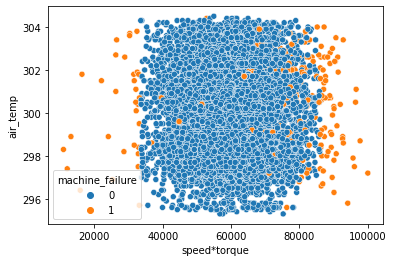

In [79]:
sns.scatterplot(data=dv, x='speed*torque', y='air_temp', hue='machine_failure')

Seems like positive entries are split into two groups: low speed/torque and high speed/torque

## Machine Learning
We will be using RandomForestClassifier and LinearSVC to tackle this classification problem, which is to predict which component will experience machine failure by looking at the component's features
### Random Forest Classifier

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

maintenance = df.drop(['UDI', 'Product ID'], axis=1)
feature_columns = ['quality', 'air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear']
target_columns = ['machine_failure', 'twf', 'hdf', 'pwf', 'osf', 'rnf']
maintenance.columns = feature_columns + target_columns

X = maintenance[feature_columns]
y = maintenance['machine_failure']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      random_state=42, 
                                                      test_size=0.2)

standard_scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(categories=[['L', 'M', 'H']])
simple_imputer = SimpleImputer(strategy='median')
poly_features = PolynomialFeatures(degree=2) # 2nd-degree polynomial

Add `speed_times_torque` as a new feature

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin
rotational_speed, torque = 3, 4
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return;
    def fit(self, X, y=None):
        return self;
    def transform(self, X, y=None):
        #speed_times_torque = X[:,rotational_speed] * X[:,torque]
        #return np.c_[X, speed_times_torque];
        inv_speed = np.ones(shape=X.shape[0]) / X[:,rotational_speed]
        inv_torque = np.ones(shape=X.shape[0]) / X[:,torque]
        return np.c_[X, inv_speed, inv_torque];
        
    
attribs_adder = CombinedAttributesAdder()

In [124]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('simple_imputer', simple_imputer),
    
    ('poly_features', poly_features),
    #('attribs_adder', attribs_adder),
    ('std_scaler', standard_scaler)
])

cat_pipeline = Pipeline([
    ('ordinal_encoder', ordinal_encoder)
])

In [125]:
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, ['quality'])
])

In [126]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(random_state=42)

In [127]:
full_pipeline = Pipeline([
    ('preprocess_pipeline', preprocess_pipeline),
    ('model', rfc_model)
])

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly_features',
                                                                   PolynomialFeatures()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['air_temp', 'process_temp',
                                                   'rotational_speed', 'torque',
                                                   'tool_wear']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(categories=[['L',
                                                                                               'M',
                                                                                               'H']]))]),
                                                  ['quality'])])),
                ('model', RandomForestClassifier(random_state=42))])

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier (Validation)')

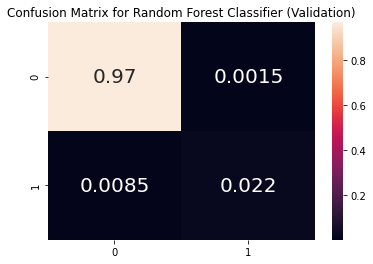

In [128]:
from sklearn.metrics import confusion_matrix
y_valid_pred = full_pipeline.predict(X_valid)

plt.figure()
sns.heatmap(confusion_matrix(y_valid, y_valid_pred)/y_valid.shape[0], annot=True, annot_kws={'size':20})
plt.title('Confusion Matrix for Random Forest Classifier (Validation)')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Classifier (Training)')

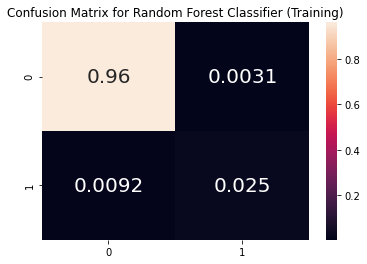

In [129]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(full_pipeline, X_train, y_train, cv=5)

plt.figure()
sns.heatmap(confusion_matrix(y_train, y_train_pred)/y_train.shape[0], annot=True, annot_kws={'size':20})
plt.title('Confusion Matrix for Random Forest Classifier (Training)')

In [130]:
from sklearn.metrics import precision_score, recall_score
print('Training Recall Score: ', recall_score(y_train, y_train_pred))
print('Training Precision Score: ', precision_score(y_train, y_train_pred))
print('Validation Recall Score: ', recall_score(y_valid, y_valid_pred))
print('Validation Precision Score: ', precision_score(y_valid, y_valid_pred))

Training Recall Score:  0.7338129496402878
Training Precision Score:  0.8908296943231441
Validation Recall Score:  0.7213114754098361
Validation Precision Score:  0.9361702127659575


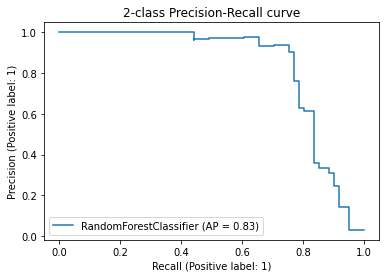

In [131]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    full_pipeline, X_valid, y_valid, name="RandomForestClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

### Support Vector Machines (SVM) Classifier

In [132]:
def plot_learning_curves(model, X, y, batch_size=100):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    train_precision, valid_precision = [], []
    train_recall, valid_recall = [], []
    batches = list(range(0, len(X_train), batch_size))
    for m in batches:
        model.fit(X_train[:], y_train)
        y_train_pred = model.predict(X_train)
        y_valid_pred = model.predict(X_valid)
        train_precision.append(precision_score(y_train, y_train_pred))
        valid_precision.append(precision_score(y_valid, y_valid_pred))
        train_recall.append(recall_score(y_train, y_train_pred))
        valid_recall.append(recall_score(y_valid, y_valid_pred))  
    fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(12,6))
    ax[0] = plt.plot(train_precision, label='train precision', color='b')     
    ax[0] = plt.plot(valid_precision, label='valid precision', color='r')    
    ax[1] = plt.plot(train_recall, label='train recall', color='b')     
    ax[1] = plt.plot(valid_recall, label='valid recall', color='r')  

In [133]:
from sklearn.svm import LinearSVC

svc_model = LinearSVC()

full_pipeline = Pipeline([
    ('preprocess_pipeline', preprocess_pipeline),
    ('model', svc_model)
])

full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess_pipeline',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly_features',
                                                                   PolynomialFeatures()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['air_temp', 'process_temp',
                                                   'rotational_speed', 'torque',
                                                   'tool_wear']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('ordinal_encoder',
                                                                   OrdinalEncoder(categories=[['L',
                                                                                               'M',
                                                                                               'H']]))]),
                                                  ['quality'])])),
                ('model', LinearSVC())])

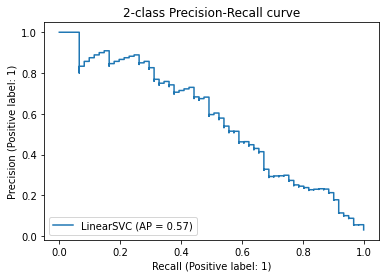

In [134]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    full_pipeline, X_valid, y_valid, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

Text(0.5, 1.0, 'Confusion Matrix for LinearSVC (Validation)')

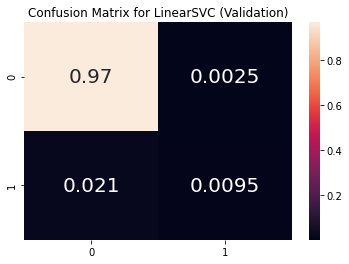

In [135]:
from sklearn.metrics import confusion_matrix
y_valid_pred = full_pipeline.predict(X_valid)

plt.figure()
sns.heatmap(confusion_matrix(y_valid, y_valid_pred)/y_valid.shape[0], annot=True, annot_kws={'size':20})
plt.title('Confusion Matrix for LinearSVC (Validation)')

Text(0.5, 1.0, 'Confusion Matrix for LinearSVC (Training)')

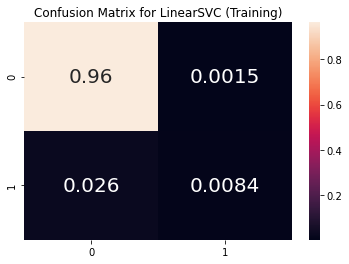

In [136]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(full_pipeline, X_train, y_train, cv=5)

plt.figure()
sns.heatmap(confusion_matrix(y_train, y_train_pred)/y_train.shape[0], annot=True, annot_kws={'size':20})
plt.title('Confusion Matrix for LinearSVC (Training)')

In [137]:
from sklearn.metrics import precision_score, recall_score
print('Training Recall Score: ', recall_score(y_train, y_train_pred))
print('Training Precision Score: ', precision_score(y_train, y_train_pred))
print('Validation Recall Score: ', recall_score(y_valid, y_valid_pred))
print('Validation Precision Score: ', precision_score(y_valid, y_valid_pred))

Training Recall Score:  0.24100719424460432
Training Precision Score:  0.8481012658227848
Validation Recall Score:  0.3114754098360656
Validation Precision Score:  0.7916666666666666


It seems that SVM performed badly (much worse than RandomTreeClassifier), might be because the positive samples are split into two groups (see data visualization in pair plot)